# <center> EDA-4-10. Практика. Статистические тесты в контексте EDA.

## <center> Исследование данных HR-агенства.

HR-агентство изучает тренды на рынке труда в IT. Компания хочет провести исследование на основе данных о зарплатах в сфере Data Science за 2020–2022 годы. Нам дали некоторые данные, которые и необходимо проанализировать для получение ответов на некоторые вопросы. Немного подробнее о данных:

|*Название столбца*|*Описание*                                                                                                                                                                    |
|:----------------:|------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
|work_year         |Год, котором была выплачена зарплата.                                            |
|experience_level  |Опыт работы на этой должности в течение года со следующими возможными значениями: <br>  - EN — Entry-level/Junior; <br>  - MI — Mid-level/Intermediate; <br>  - SE — Senior-level/Expert; <br>  - EX — Executive-level/Director.|
|employment_type   |Тип трудоустройства для этой роли: <br> - PT — неполный рабочий день; <br> - FT — полный рабочий день; <br> - CT — контракт; <br> - FL — фриланс.|
|job_title         |Роль, в которой соискатель работал в течение года.|
|salary            |Общая выплаченная валовая сумма заработной платы.|
|salary_currency   |Валюта выплачиваемой заработной платы в виде кода валюты ISO 4217.|
|salary_in_usd     |Зарплата в долларах США (валютный курс, делённый на среднее значение курса доллара США за соответствующий год через fxdata.foorilla.com).|
|employee_residence|Основная страна проживания сотрудника в течение рабочего года в виде кода страны ISO 3166.|
|remote_ratio|Общий объём работы, выполняемой удалённо. Возможные значения: <br> - 0 — удалённой работы нет (менее 20 %); <br> - 50 — частично удалённая работа; <br> - 100 — полностью удалённая работа (более 80 %).|
|company_location|Страна главного офиса работодателя или филиала по контракту в виде кода страны ISO 3166.|
|company_size|Среднее количество людей, работавших в компании в течение года: <br> - S — менее 50 сотрудников (небольшая компания); - M — от 50 до 250 сотрудников (средняя компания); <br> - L — более 250 сотрудников (крупная компания).|

### Цели и задачи работы:

Выяснить, какие факторы влияют на зарплату специалиста Data Scientist.

А также ответить на ключевые вопросы HR-агентства:
- Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?
- Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?
- Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?
- Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?
- Если вы найдёте в данных интересные закономерности, также отметьте их в своём анализе.

Продемонстривать использование разных тестов для проверки статистической значимости сделанных выводов:

1. тесты для количественного признака:
    - для одной выборки;
    - для двух выборок;
    - для нескольких выборок;
2. тест для категориальных признаков.

In [112]:
# импортируем необходимые библиотеки
import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.api as sm
from statsmodels import stats as sms
import category_encoders as ce

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# делаем визуальную настройку графиков
sns.set_theme("notebook") 
sns.set_palette("Set2") 

Данные были скопированы из урока, но я продублировал их на [Google Drive](https://drive.google.com/file/d/1-Jmg4_s6DIm0MQP13Q6jRhDd8euweRgd/view?usp=drive_link), для удобства.

In [113]:
salaries_data = pd.read_csv('data/ds_salaries.csv', index_col=0)
display(salaries_data)

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L
...,...,...,...,...,...,...,...,...,...,...,...
602,2022,SE,FT,Data Engineer,154000,USD,154000,US,100,US,M
603,2022,SE,FT,Data Engineer,126000,USD,126000,US,100,US,M
604,2022,SE,FT,Data Analyst,129000,USD,129000,US,0,US,M
605,2022,SE,FT,Data Analyst,150000,USD,150000,US,100,US,M


In [114]:
# Задаём уровень значимости
alpha = 0.05
print(f'Уровень значимости alpha = {alpha}.')

Уровень значимости alpha = 0.05.


## <center> Очистка данных

In [115]:
#Выведем основную информацию о датасете
display(salaries_data.info())


#Проверка данных на наличие дубликатов
print('Количество дубликатов:', 
salaries_data[salaries_data.duplicated()].shape[0])

<class 'pandas.core.frame.DataFrame'>
Index: 607 entries, 0 to 606
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           607 non-null    int64 
 1   experience_level    607 non-null    object
 2   employment_type     607 non-null    object
 3   job_title           607 non-null    object
 4   salary              607 non-null    int64 
 5   salary_currency     607 non-null    object
 6   salary_in_usd       607 non-null    int64 
 7   employee_residence  607 non-null    object
 8   remote_ratio        607 non-null    int64 
 9   company_location    607 non-null    object
 10  company_size        607 non-null    object
dtypes: int64(4), object(7)
memory usage: 56.9+ KB


None

Количество дубликатов: 42


Размерность датасета 607х11. Пропущеных значений и дубликатов нет.

Сами данные и их типы подозрений также не вызывают, кроме столбца remote_ratio, которые хоть и является категориальным, но представлен в числовом формате, несмотря на то, что он может иметь всего 3 значения.

У нас имеюются колонки, связанные с заработными платами, аж 3 штуки. Думаю, целесообразно будет убрать колонки "salary" и "salary_currency", так как из них выведен более универсальный признак, трансформирующий заработную плату в доллары.

In [116]:
salaries_data = salaries_data.drop(columns=['salary', 'salary_currency'])
salaries_data

,work_year,experience_level,employment_type,job_title,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2020,MI,FT,Data Scientist,79833,DE,0,DE,L
1,2020,SE,FT,Machine Learning Scientist,260000,JP,0,JP,S
2,2020,SE,FT,Big Data Engineer,109024,GB,50,GB,M
3,2020,MI,FT,Product Data Analyst,20000,HN,0,HN,S
4,2020,SE,FT,Machine Learning Engineer,150000,US,50,US,L
...,...,...,...,...,...,...,...,...,...
602,2022,SE,FT,Data Engineer,154000,US,100,US,M
603,2022,SE,FT,Data Engineer,126000,US,100,US,M
604,2022,SE,FT,Data Analyst,129000,US,0,US,M
605,2022,SE,FT,Data Analyst,150000,US,100,US,M


Теперь для удобства перекодирую признак remote_ratio. Так как в задаче нет ни слова о том, что данные будут использоваться для машинного обучения, закодирую в читабельном для человека варианте.

In [117]:
salaries_data['remote_ratio'] = salaries_data['remote_ratio'].replace(
    {0:'around_zero', 50:'half-time', 100:'full-time'})

salaries_data

,work_year,experience_level,employment_type,job_title,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2020,MI,FT,Data Scientist,79833,DE,around_zero,DE,L
1,2020,SE,FT,Machine Learning Scientist,260000,JP,around_zero,JP,S
2,2020,SE,FT,Big Data Engineer,109024,GB,half-time,GB,M
3,2020,MI,FT,Product Data Analyst,20000,HN,around_zero,HN,S
4,2020,SE,FT,Machine Learning Engineer,150000,US,half-time,US,L
...,...,...,...,...,...,...,...,...,...
602,2022,SE,FT,Data Engineer,154000,US,full-time,US,M
603,2022,SE,FT,Data Engineer,126000,US,full-time,US,M
604,2022,SE,FT,Data Analyst,129000,US,around_zero,US,M
605,2022,SE,FT,Data Analyst,150000,US,full-time,US,M


Проведём корреляционный анализ признаков с помощью тепловой карты.

<Axes: >

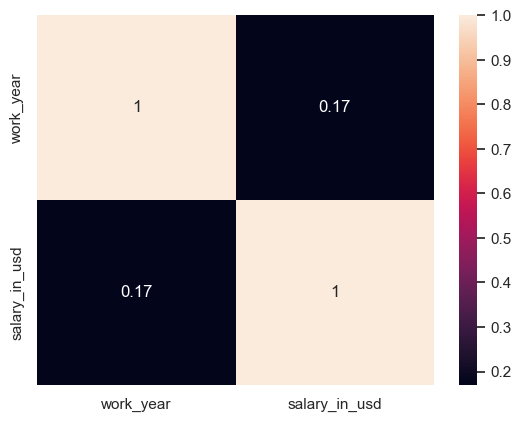

In [118]:
sns.heatmap(salaries_data.corr(numeric_only=True), annot=True)

Ничего подозрительного, числовые признаки логически зависимы, что довольно очевидно; но очень слабо.

На самом деле, признак года едва ли можно назвать числовым. Его следовалы бы закодировать, но делать этого не буду, опять же, для лучшей читаемости. Но изменю тип данных признаков.

In [119]:
coll_list = ['work_year', 'experience_level', 'employment_type', 'job_title', 'employee_residence', 'remote_ratio', 'company_location', 'company_size']
salaries_data[coll_list] = salaries_data[coll_list].astype('category')

salaries_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 607 entries, 0 to 606
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   work_year           607 non-null    category
 1   experience_level    607 non-null    category
 2   employment_type     607 non-null    category
 3   job_title           607 non-null    category
 4   salary_in_usd       607 non-null    int64   
 5   employee_residence  607 non-null    category
 6   remote_ratio        607 non-null    category
 7   company_location    607 non-null    category
 8   company_size        607 non-null    category
dtypes: category(8), int64(1)
memory usage: 22.4 KB


Рассмотрим признак Job_title. У нас в задании есть информация о необходимости рассмотрения только вакансий специалистов data scientist и data engineer. Остальных отметаем. На всякий случай здесь сделаю копию датасета, она может пригодиться далее.

In [120]:
#Список нужных нам профессий
jobs_in_research = ['Data Scientist', 'Data Engineer']

#Копия данных со всеми профессиями на будущее
salaries_data_copy = salaries_data.copy()


salaries_data['job_title'] = salaries_data['job_title'].apply(lambda x: x if x in jobs_in_research else 'Other')

salaries_data['job_title'].value_counts()

job_title
Other             332
Data Scientist    143
Data Engineer     132
Name: count, dtype: int64

## <center> Описательный анализ данных

Посмотрим на признаки более внимательно, а также визуализирем их и попробуем найти зависимости и интересные моменты.

Для начала рассмотрим зависимость заработной платы от года.

In [121]:
# Весь рынок исходя из предоставленных данных
fig1 = px.box(
    data_frame=salaries_data,
    x = 'salary_in_usd',
    y = 'work_year',
    title='Коробчатая диаграмма зависимости ЗП от рабочего года',
    labels={'work_year':'Год наблюдения',
            'salary_in_usd':'Заработная плата в USD'}
)

fig1

А теперь посмотрим на распределение заработных плат дата-инженеров и дата-саентистов отдельно:

In [122]:
# ЗП дата-инженеров
data_engineer_mask = salaries_data[salaries_data['job_title'] == 'Data Engineer']

fig2 = px.box(
    data_frame=data_engineer_mask,
    x = 'salary_in_usd',
    y = 'work_year',
    title='Коробчатая диаграмма зависимости ЗП дата-инженеров от рабочего года',
    labels={'work_year':'Год наблюдения',
            'salary_in_usd':'Заработная плата в USD'}
)

fig2

In [123]:
# ЗП дата-саентистов
data_scientist_mask = salaries_data[salaries_data['job_title'] == 'Data Scientist']

fig3 = px.box(
    data_frame=data_scientist_mask,
    x = 'salary_in_usd',
    y = 'work_year',
    title='Коробчатая диаграмма зависимости ЗП дата-саентистов от рабочего года',
    labels={'work_year':'Год наблюдения',
            'salary_in_usd':'Заработная плата в USD'}
)

fig3

In [124]:
# Дополнительно изучим потенциальные выбросы
display(salaries_data_copy[(salaries_data_copy['job_title'] == 'Data Engineer') & (salaries_data_copy['salary_in_usd'] > 300000)])
display(salaries_data_copy[(salaries_data_copy['job_title'] == 'Data Scientist') & (salaries_data_copy['salary_in_usd'] > 300000)])

,work_year,experience_level,employment_type,job_title,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
482,2022,EX,FT,Data Engineer,324000,US,full-time,US,M


,work_year,experience_level,employment_type,job_title,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
63,2020,SE,FT,Data Scientist,412000,US,full-time,US,L


#### Из этих графиков можно сделать следующие выводы:

1) В целом зарплата обеих должностей увеличивалась из года в год. В 2020, скорее всего из-за Covid-19, минимальная планка ЗП была чуть выше обычной. Но для для полноты утверждения нужны данные за более далёкие годы. Медианные же значения увеличивались из года в год.

По сравнению с остальным рынком, зарплаты обеих исследуемых профессий в 2020 и 2021 были в среднем чуть ниже рынка, но в 2022 они сильно выросли, догнали и даже чуть перегнали остальной рынок. Полагаю, это связано с всеобщей популярностью нейросетей, которая особенно начала прослеживаться как раз с 2022.

2) Максимальные вилки и медианные ЗП обеих должностей увеличивались из года в год. Даже с учётом прошлого утверждения.

3) На графиках обеих профессий имеется по одному потенциальному выбросу. Сказать, что это точно выбросы, нельзя, так как при их более подробном исследовании выясняется, что один из них директор компании из не самой скромной и маленькой компании США (размер компании средний), а это случай особый, и зарплата тут может быть самая разная. Второй выброс - сеньёр Дата-саентист из большой компании США. Возможно, этот кадр стоил своей ЗП. 

В обоих случаях пока не вижу смысла списывать их из исследований.

Посмотрим на градацию заработной платы в зависимости от уровня навыков работника (Среди дата-инженеров и дата-саентистов)

In [125]:
# ЗП дата-инженеров

fig4 = px.box(
    data_frame=data_engineer_mask,
    x = 'salary_in_usd',
    y = 'experience_level',
    title='Коробчатая диаграмма зависимости ЗП дата-инженеров от уровня навыков',
    labels={'experience_level':'Уровень навыков',
            'salary_in_usd':'Заработная плата в USD'}
)

fig4

In [126]:
# ЗП дата-саентистов

fig5 = px.box(
    data_frame=data_scientist_mask,
    x = 'salary_in_usd',
    y = 'experience_level',
    title='Коробчатая диаграмма зависимости ЗП дата-саентистов от уровня навыков',
    labels={'experience_level':'Уровень навыков',
            'salary_in_usd':'Заработная плата в USD'}
)

fig5

In [127]:
# Количество людей с должностью директора
display(salaries_data[(salaries_data['experience_level'] == 'EX') &
                      ((salaries_data['job_title'] == 'Data Engineer') | 
                       (salaries_data['job_title'] == 'Data Scientist'))])


,work_year,experience_level,employment_type,job_title,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
309,2022,EX,FT,Data Engineer,242000,US,full-time,US,M
310,2022,EX,FT,Data Engineer,200000,US,full-time,US,M
482,2022,EX,FT,Data Engineer,324000,US,full-time,US,M
483,2022,EX,FT,Data Engineer,216000,US,full-time,US,M


Итого у нас имеется довольно стандартное распределение заработных плат в зависимости от предполагаемого уровня умений, где в порядке возрастания идут: Junior --> Middle --> Senior --> Team Lead или директор.

Всего у нас в таблице 4 лида или директора, все из США с внушительными заработными платами. Интересно, что у нас есть данные о них только за 2022 год.

Посмотрим, есть ли различие зарплат дата-инженеров и дата-саентистов в зависимости от размера компании.

In [128]:
# ЗП дата-саентистов

fig6 = px.box(
    data_frame=data_scientist_mask,
    x = 'salary_in_usd',
    y = 'company_size',
    title='Коробчатая диаграмма зависимости ЗП дата-саентистов от размера компании',
    labels={'company_size':'Размер компании',
            'salary_in_usd':'Заработная плата в USD'}
)

fig6

In [129]:
# ЗП дата-инженеров

fig7 = px.box(
    data_frame=data_engineer_mask,
    x = 'salary_in_usd',
    y = 'company_size',
    title='Коробчатая диаграмма зависимости ЗП дата-инженеров от размера компании',
    labels={'company_size':'Размер компании',
            'salary_in_usd':'Заработная плата в USD'}
)

fig7

Судя по графикам, можно сказать, что платят лучше всего обоим специальностям в компаниях средних размеров. Видимо, у маленьких денег не так много, а большие предпочитают больше вкладывать в расширение компании, её компетенций и влияния.

Посмотрим, есть ли взаимосвязь между размерами компании и наличием долностей Data Scientist и Data Engineer.

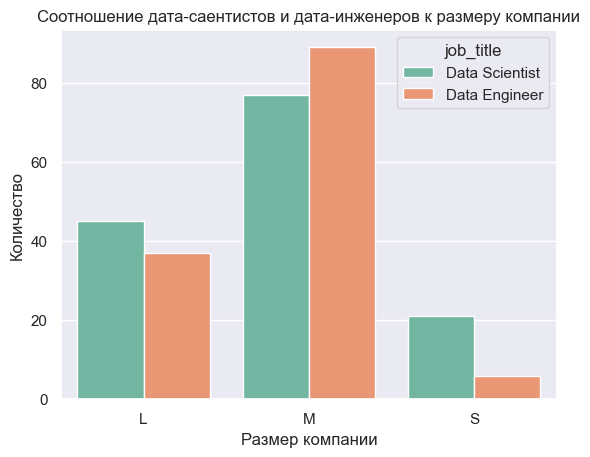

In [130]:
#Маска только с дата-инженерами и дата-саентистами
mask = salaries_data[(salaries_data['job_title'] == 'Data Engineer') | 
                       (salaries_data['job_title'] == 'Data Scientist')]

ax = sns.countplot(data=mask, x=mask['company_size'], hue='job_title')
ax.set(xlabel='Размер компании', ylabel='Количество')
plt.title('Соотношение дата-саентистов и дата-инженеров к размеру компании')
plt.show()

fig8 = px.pie(mask, values='company_size', names='company_size')
fig8

Интересная картина. 